In [101]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
 

In [102]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [103]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [104]:
ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE = BATCH_SIZE*strategy.num_replicas_in_sync
BATCH_SIZE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


256

In [105]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [106]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [107]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [108]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [109]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [110]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [111]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#=================

In [112]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [113]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [114]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [115]:
str(tr)

'                        Patient  Weeks   FVC    Percent  Age   Sex  \\\n0     ID00007637202177411956430     -4  2315  58.253649   79  Male   \n1     ID00007637202177411956430      5  2214  55.712129   79  Male   \n2     ID00007637202177411956430      7  2061  51.862104   79  Male   \n3     ID00007637202177411956430      9  2144  53.950679   79  Male   \n4     ID00007637202177411956430     11  2069  52.063412   79  Male   \n...                         ...    ...   ...        ...  ...   ...   \n1530  ID00426637202313170790466     13  2712  66.594637   73  Male   \n1531  ID00426637202313170790466     19  2978  73.126412   73  Male   \n1532  ID00426637202313170790466     31  2908  71.407524   73  Male   \n1533  ID00426637202313170790466     43  2975  73.052745   73  Male   \n1534  ID00426637202313170790466     59  2774  68.117081   73  Male   \n\n     SmokingStatus  WHERE  Confidence Patient_Week  ...  base_week  Male  \\\n0        Ex-smoker  train         NaN          NaN  ...        0.0

### BASELINE NN 

In [124]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def score_fold(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#============================#
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh,D,ML):
    z = L.Input((nh,), name="Patient")
    #x = L.Dense(2112, activation="relu", name="d0")(z)
    #x = L.Dense(1056, activation="relu", name="d1")(z)
    #x = L.Dropout(.2, name="do2")(z)
    x = L.Dense(D, activation="relu", name="d2")(z)
    #x = L.Dense(256, activation="relu", name="d3")(z)
    x = L.Dense(D, activation="relu", name="d4")(x)
    #x = L.Dense(16, activation="relu", name="d5")(x)

    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)

    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])

    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(ML), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

my_callbacks = [
   tf.keras.callbacks.EarlyStopping(patience=200, mode='max',monitor=[score]),
   tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',monitor=[score],save_best_only=True, mode = 'max'),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [117]:
y = tr['FVC'].values.astype(np.float32)
z = tr[FE].values.astype(np.float32)
ze = sub[FE].values.astype(np.float32)
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [118]:
with strategy.scope():
    net = make_model(nh,D=100,ML=.8)

print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d4 (Dense)                      (None, 100)          10100       d2[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d4[0][0]                         
________________________________________________________________________________________________

In [119]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)


In [120]:
#epochs=[100,200]
#batches=[64,128]

#neural_network = KerasClassifier(build_fn=make_model(nh), verbose=0)
#hyperparameters = dict(epochs=epochs, 
#                       batch_size=batches)

#grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, n_jobs=-1, cv=3)
#from numpy import * 

In [121]:
#grid_result = grid.fit(reshape(tr[FE],tr[FE].shape), reshape(tr['FVC'],tr['FVC'].shape))
#grid_result.best_params_

FOLD 1
train [30.696556091308594, 6.644939422607422]
val [30.766624450683594, 6.598270416259766]
predict val...
predict test...
133.05984 274.02014
118.39258 274.02014 479.38135 1.0
FOLD 2
train [31.226743698120117, 6.660839080810547]
val [30.695993423461914, 6.715459823608398]
predict val...
predict test...
131.13551 276.17792
127.23303 276.17792 471.90723 1.0
FOLD 3
train [30.088600158691406, 6.610232353210449]
val [33.746185302734375, 6.778390884399414]
predict val...
predict test...
146.87589 264.07074
100.89966 264.07074 576.7197 1.0
FOLD 4
train [31.646528244018555, 6.6710004806518555]
val [33.12985610961914, 6.641823768615723]
predict val...
predict test...
146.18066 248.59528
78.879395 248.59528 420.1709 1.0
FOLD 5
train [30.22873878479004, 6.608458042144775]
val [33.40381622314453, 6.704052448272705]
predict val...
predict test...
144.90843 238.69162
85.93762 238.69162 424.7046 1.0
FOLD 6
train [29.272130966186523, 6.573548316955566]
val [32.210453033447266, 6.771172523498535]

train [30.358051300048828, 6.606923580169678]
val [29.60151481628418, 6.6154375076293945]
predict val...
predict test...
124.06029 259.23154
150.81335 259.23154 417.54053 1.0
FOLD 48
train [27.897594451904297, 6.499150276184082]
val [36.294525146484375, 6.685854911804199]
predict val...
predict test...
158.26205 229.88101
112.20398 229.88101 484.55957 1.0
FOLD 49
train [30.037038803100586, 6.594184875488281]
val [29.116844177246094, 6.504361152648926]
predict val...
predict test...
127.11054 228.41893
108.76141 228.41893 362.19824 1.0
FOLD 50
train [29.70334815979004, 6.571998596191406]
val [32.550621032714844, 6.665587425231934]
predict val...
predict test...
141.38986 236.205
104.38367 236.205 393.04346 1.0
FOLD 51
train [34.977291107177734, 6.629694938659668]
val [34.97207260131836, 6.600438117980957]
predict val...
predict test...
131.2106 271.83685
122.72974 271.83685 477.3252 1.0
FOLD 52
train [34.57533264160156, 6.601718902587891]
val [34.680450439453125, 6.628419399261475]
pred

train [33.514930725097656, 6.546181678771973]
val [41.53068923950195, 6.708395004272461]
predict val...
predict test...
155.21565 240.71677
115.68396 240.71677 505.22266 1.0
FOLD 94
train [34.98744583129883, 6.602511405944824]
val [33.42472457885742, 6.493968963623047]
predict val...
predict test...
125.785065 227.02782
92.135376 227.02782 373.2788 1.0
FOLD 95
train [33.357723236083984, 6.552081108093262]
val [37.75050735473633, 6.652715682983398]
predict val...
predict test...
143.01688 236.22165
120.12805 236.22165 367.354 1.0
FOLD 96
train [34.243980407714844, 6.578795433044434]
val [37.518829345703125, 6.744870185852051]
predict val...
predict test...
138.97577 247.26898
125.68347 247.26898 411.45508 1.0
FOLD 97
train [35.06781005859375, 6.609925746917725]
val [34.21543884277344, 6.616328239440918]
predict val...
predict test...
124.05387 261.07162
167.36487 261.07162 412.06152 1.0
FOLD 98
train [33.52341079711914, 6.545344352722168]
val [41.51416015625, 6.708529949188232]
predict 

train [40.68708801269531, 6.629997253417969]
val [36.66423797607422, 6.5128607749938965]
predict val...
predict test...
122.643555 231.36914
89.050415 231.36914 379.20923 1.0
FOLD 140
train [38.03007888793945, 6.558180332183838]
val [42.75737380981445, 6.652887344360352]
predict val...
predict test...
141.78879 237.8609
107.055176 237.8609 408.3213 1.0
FOLD 141
train [39.42227554321289, 6.59928035736084]
val [40.084136962890625, 6.595267295837402]
predict val...
predict test...
130.46657 254.13768
121.02356 254.13768 434.7295 1.0
FOLD 142
train [38.621089935302734, 6.5758185386657715]
val [38.13352966308594, 6.574634552001953]
predict val...
predict test...
120.29489 255.52187
145.49219 255.52187 426.32568 1.0
FOLD 143
train [38.007293701171875, 6.546316623687744]
val [47.276397705078125, 6.706886291503906]
predict val...
predict test...
155.08258 240.83784
117.77551 240.83784 503.33203 1.0
FOLD 144
train [39.7154655456543, 6.597914695739746]
val [37.7000617980957, 6.4871931076049805]


train [42.448368072509766, 6.558680057525635]
val [48.05476760864258, 6.654106140136719]
predict val...
predict test...
142.45071 239.94844
121.27252 239.94844 395.94287 1.0
FOLD 186
train [42.664710998535156, 6.565962314605713]
val [47.237850189208984, 6.755136013031006]
predict val...
predict test...
138.14296 248.21445
125.50867 248.21445 422.00488 1.0
FOLD 187
train [44.6812858581543, 6.611593723297119]
val [43.606075286865234, 6.6259074211120605]
predict val...
predict test...
124.64731 262.49457
138.8241 262.49457 436.25293 1.0
FOLD 188
train [40.72214889526367, 6.5040106773376465]
val [54.157127380371094, 6.691527366638184]
predict val...
predict test...
158.72316 232.39908
122.6488 232.39908 474.35645 1.0
FOLD 189
train [45.619476318359375, 6.632183074951172]
val [41.731475830078125, 6.525090217590332]
predict val...
predict test...
124.893936 231.2
81.17627 231.2 383.3911 1.0
FOLD 190
train [43.72996139526367, 6.579514503479004]
val [48.02149200439453, 6.671686172485352]
predi

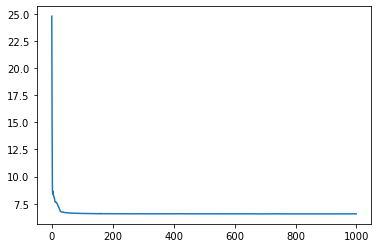

FOLD 201
train [29.49599838256836, 6.576401710510254]
val [32.43968963623047, 6.7806196212768555]
predict val...
predict test...
139.3568 243.25183
111.56677 243.25183 429.16504 1.0
FOLD 202
train [29.596540451049805, 6.580010890960693]
val [30.60071563720703, 6.642650604248047]
predict val...
predict test...
127.861946 254.31981
124.98047 254.31981 440.75586 1.0
FOLD 203
train [28.44521141052246, 6.524138450622559]
val [36.36286926269531, 6.699497222900391]
predict val...
predict test...
158.88457 233.61859
104.95105 233.61859 512.5405 1.0
FOLD 204
train [31.47913932800293, 6.646331787109375]
val [29.40774917602539, 6.543733596801758]
predict val...
predict test...
129.27896 230.08759
77.59369 230.08759 384.8584 1.0
FOLD 205
train [29.8209171295166, 6.592114448547363]
val [32.832427978515625, 6.690398216247559]
predict val...
predict test...
142.78336 238.57587
89.4881 238.57587 423.77783 1.0
FOLD 206
train [30.174474716186523, 6.609716892242432]
val [30.495868682861328, 6.58853244781

train [30.112085342407227, 6.601592063903809]
val [30.56327247619629, 6.593535423278809]
predict val...
predict test...
130.62823 253.15584
133.04419 253.15584 420.1538 1.0
FOLD 247
train [29.452587127685547, 6.581966400146484]
val [29.143516540527344, 6.56845760345459]
predict val...
predict test...
122.024864 251.42009
181.89612 251.42009 361.25 1.0
FOLD 248
train [27.74662208557129, 6.493182182312012]
val [36.64961624145508, 6.67979097366333]
predict val...
predict test...
159.32465 226.38959
127.92883 226.38959 426.70898 1.0
FOLD 249
train [30.21016502380371, 6.595162391662598]
val [28.58660888671875, 6.47869873046875]
predict val...
predict test...
123.818825 225.72455
103.47479 225.72455 351.40674 1.0
FOLD 250
train [28.773517608642578, 6.546777248382568]
val [32.619537353515625, 6.6527252197265625]
predict val...
predict test...
143.32016 234.04428
152.76367 234.04428 305.2876 1.0
FOLD 251
train [34.09279251098633, 6.578866004943848]
val [37.33380126953125, 6.766837120056152]
pr

train [33.91792297363281, 6.573538303375244]
val [33.73287582397461, 6.574892044067383]
predict val...
predict test...
120.00185 256.95984
141.8219 256.95984 429.7422 1.0
FOLD 293
train [32.36128616333008, 6.506390571594238]
val [42.14463424682617, 6.679712295532227]
predict val...
predict test...
157.30275 231.41643
132.66162 231.41643 442.65576 1.0
FOLD 294
train [35.84281539916992, 6.630570888519287]
val [32.448482513427734, 6.519311904907227]
predict val...
predict test...
123.20267 233.56578
90.86664 233.56578 378.53467 1.0
FOLD 295
train [33.02122116088867, 6.548121452331543]
val [37.88322448730469, 6.658924102783203]
predict val...
predict test...
142.65858 237.34222
169.71948 237.34222 325.89893 1.0
FOLD 296
train [32.536041259765625, 6.526316165924072]
val [35.70590591430664, 6.662169456481934]
predict val...
predict test...
133.13676 238.06212
120.65515 238.06212 381.54785 1.0
FOLD 297
train [33.41565704345703, 6.5587158203125]
val [34.798240661621094, 6.626657962799072]
pred

train [36.62803268432617, 6.505090236663818]
val [48.520965576171875, 6.700624465942383]
predict val...
predict test...
159.68707 233.12404
108.17139 233.12404 511.25928 1.0
FOLD 339
train [39.71244812011719, 6.606321811676025]
val [36.27988815307617, 6.487943172454834]
predict val...
predict test...
121.19297 233.7132
112.23407 233.7132 360.7588 1.0
FOLD 340
train [37.479679107666016, 6.547454833984375]
val [42.937313079833984, 6.6496124267578125]
predict val...
predict test...
143.05775 238.40271
157.3233 238.40271 307.1931 1.0
FOLD 341
train [39.53273391723633, 6.607241153717041]
val [40.161102294921875, 6.595480918884277]
predict val...
predict test...
130.48444 258.60403
130.73438 258.60403 431.91943 1.0
FOLD 342
train [38.57987976074219, 6.5740966796875]
val [39.55557632446289, 6.628781318664551]
predict val...
predict test...
125.082985 253.18933
141.81665 253.18933 418.38477 1.0
FOLD 343
train [36.37604522705078, 6.5037970542907715]
val [47.74418640136719, 6.67191743850708]
pre

train [44.429473876953125, 6.599175453186035]
val [41.68201446533203, 6.479660987854004]
predict val...
predict test...
123.673195 225.2702
90.808044 225.2702 367.27417 1.0
FOLD 385
train [41.75309371948242, 6.542014122009277]
val [48.90201187133789, 6.666016578674316]
predict val...
predict test...
145.5608 238.09566
146.45044 238.09566 352.30713 1.0
FOLD 386
train [42.228919982910156, 6.550879001617432]
val [47.26223373413086, 6.767679214477539]
predict val...
predict test...
137.77081 244.5482
167.41455 244.5482 330.4336 1.0
FOLD 387
train [42.93791961669922, 6.569808006286621]
val [43.107147216796875, 6.579161167144775]
predict val...
predict test...
121.73192 255.54507
146.34924 255.54507 416.6831 1.0
FOLD 388
train [40.65068817138672, 6.50728702545166]
val [53.850093841552734, 6.685758590698242]
predict val...
predict test...
157.69336 234.97679
137.44043 234.97679 436.70557 1.0
FOLD 389
train [45.48049545288086, 6.627776145935059]
val [40.91827392578125, 6.509529113769531]
predi

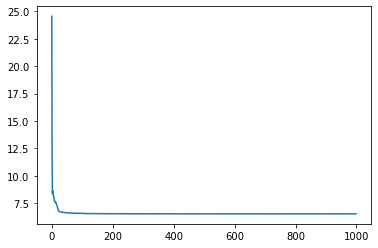

FOLD 401
train [29.35194969177246, 6.573301792144775]
val [32.50211715698242, 6.7865142822265625]
predict val...
predict test...
139.97504 246.27448
115.0459 246.27448 437.93408 1.0
FOLD 402
train [29.491905212402344, 6.572484016418457]
val [30.300113677978516, 6.622528076171875]
predict val...
predict test...
125.89467 252.42023
125.835815 252.42023 438.69434 1.0
FOLD 403
train [28.533235549926758, 6.527412414550781]
val [37.714881896972656, 6.711165428161621]
predict val...
predict test...
165.25975 233.22926
106.937744 233.22926 527.49316 1.0
FOLD 404
train [31.402597427368164, 6.638070106506348]
val [28.838937759399414, 6.520493507385254]
predict val...
predict test...
126.37065 221.06606
72.81128 221.06606 372.76416 1.0
FOLD 405
train [29.281160354614258, 6.560061454772949]
val [32.31719970703125, 6.664579391479492]
predict val...
predict test...
141.32184 228.33871
93.361084 228.33871 404.2461 1.0
FOLD 406
train [28.8945255279541, 6.548619747161865]
val [32.5056037902832, 6.76646

train [28.767629623413086, 6.543499946594238]
val [32.5684814453125, 6.795211315155029]
predict val...
predict test...
141.25146 243.33578
143.24536 243.33578 355.1206 1.0
FOLD 447
train [28.881235122680664, 6.552000999450684]
val [30.52457046508789, 6.634159088134766]
predict val...
predict test...
129.01418 247.23601
142.2207 247.23601 400.94434 1.0
FOLD 448
train [27.5093936920166, 6.486579895019531]
val [36.53401565551758, 6.668519496917725]
predict val...
predict test...
159.03021 224.25264
153.58643 224.25264 350.22998 1.0
FOLD 449
train [30.20107078552246, 6.592765808105469]
val [28.479053497314453, 6.473496437072754]
predict val...
predict test...
123.72908 224.3777
109.32971 224.3777 345.0459 1.0
FOLD 450
train [28.561519622802734, 6.548841953277588]
val [32.99557113647461, 6.669678688049316]
predict val...
predict test...
144.17061 239.70412
167.82947 239.70412 339.58496 1.0
FOLD 451
train [33.91462707519531, 6.5649309158325195]
val [37.913177490234375, 6.7969465255737305]
pr

train [33.7202262878418, 6.567330360412598]
val [34.148529052734375, 6.5937652587890625]
predict val...
predict test...
122.787895 252.72455
155.06335 252.72455 405.28223 1.0
FOLD 493
train [31.940563201904297, 6.502850532531738]
val [42.49043655395508, 6.680015563964844]
predict val...
predict test...
158.50601 232.09406
169.3175 232.09406 289.9375 1.0
FOLD 494
train [33.7178955078125, 6.573736667633057]
val [32.00065612792969, 6.505863666534424]
predict val...
predict test...
123.15795 232.69344
132.44116 232.69344 296.69873 1.0
FOLD 495
train [33.00218963623047, 6.542784214019775]
val [37.75812530517578, 6.661246299743652]
predict val...
predict test...
143.21803 237.1859
139.57336 237.1859 371.73828 1.0
FOLD 496
train [32.826045989990234, 6.5301408767700195]
val [36.70778274536133, 6.73881196975708]
predict val...
predict test...
136.15292 238.43289
162.37146 238.43289 291.93213 1.0
FOLD 497
train [33.259525299072266, 6.549699306488037]
val [35.66950607299805, 6.6567277908325195]
p

train [36.31795120239258, 6.511135101318359]
val [47.901893615722656, 6.681687355041504]
predict val...
predict test...
157.32495 236.77713
163.28247 236.77713 348.97998 1.0
FOLD 539
train [39.19404220581055, 6.591526031494141]
val [37.732662200927734, 6.491692066192627]
predict val...
predict test...
125.75219 231.49048
114.533936 231.49048 349.55225 1.0
FOLD 540
train [37.48112869262695, 6.5475568771362305]
val [42.70868682861328, 6.653207302093506]
predict val...
predict test...
141.53697 238.27661
158.40808 238.27661 315.54932 1.0
FOLD 541
train [37.47997283935547, 6.544554233551025]
val [42.34761047363281, 6.781294822692871]
predict val...
predict test...
139.32434 249.08704
173.11304 249.08704 320.54346 1.0
FOLD 542
train [38.25630187988281, 6.569862365722656]
val [38.5364875793457, 6.576104164123535]
predict val...
predict test...
121.48746 255.59619
162.0188 255.59619 409.8369 1.0
FOLD 543
train [36.04108428955078, 6.494297981262207]
val [49.08309555053711, 6.666608810424805]
p

train [42.88821029663086, 6.573902130126953]
val [40.82304763793945, 6.482100963592529]
predict val...
predict test...
121.30755 220.26425
86.33765 220.26425 361.73193 1.0
FOLD 585
train [41.70512390136719, 6.546543121337891]
val [49.1169319152832, 6.671772480010986]
predict val...
predict test...
145.57333 241.6932
163.95361 241.6932 331.1084 1.0
FOLD 586
train [41.88959503173828, 6.546082973480225]
val [46.325767517089844, 6.741593837738037]
predict val...
predict test...
136.328 251.36426
158.54614 251.36426 371.86182 1.0
FOLD 587
train [42.71223449707031, 6.569211483001709]
val [43.59117126464844, 6.586752891540527]
predict val...
predict test...
122.83748 255.84726
138.65222 255.84726 428.23535 1.0
FOLD 588
train [40.1826171875, 6.501651763916016]
val [53.94792175292969, 6.678881645202637]
predict val...
predict test...
157.40111 238.37321
161.28772 238.37321 330.71338 1.0
FOLD 589
train [42.77432632446289, 6.570295810699463]
val [41.35067367553711, 6.489129543304443]
predict val.

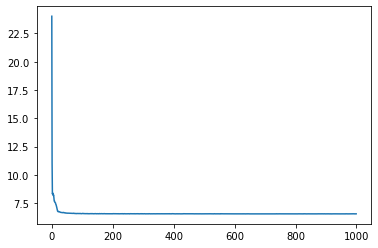

FOLD 601
train [28.815853118896484, 6.556406497955322]
val [31.946016311645508, 6.743188381195068]
predict val...
predict test...
138.69496 249.77257
117.56702 249.77257 442.0 1.0
FOLD 602
train [29.370508193969727, 6.563832759857178]
val [29.413890838623047, 6.574739933013916]
predict val...
predict test...
121.47218 245.57394
138.30798 245.57394 416.03516 1.0
FOLD 603
train [28.253374099731445, 6.51645040512085]
val [36.12369155883789, 6.681860446929932]
predict val...
predict test...
157.42513 233.96921
107.690796 233.96921 513.7466 1.0
FOLD 604
train [30.00688934326172, 6.591239929199219]
val [29.53043556213379, 6.496801376342773]
predict val...
predict test...
128.35106 216.9165
84.16113 216.9165 364.90625 1.0
FOLD 605
train [29.566997528076172, 6.566636085510254]
val [32.18305969238281, 6.662532806396484]
predict val...
predict test...
140.52097 223.54268
97.211365 223.54268 394.35352 1.0
FOLD 606
train [29.216176986694336, 6.563333034515381]
val [32.092926025390625, 6.7564101219

train [28.91305160522461, 6.554080009460449]
val [30.588367462158203, 6.646234512329102]
predict val...
predict test...
129.67192 245.4314
165.83533 245.4314 375.18164 1.0
FOLD 648
train [26.81618309020996, 6.467665195465088]
val [36.68803787231445, 6.670292854309082]
predict val...
predict test...
157.62213 227.87335
126.00879 227.87335 275.562 1.0
FOLD 649
train [29.713838577270508, 6.586656093597412]
val [28.072046279907227, 6.47582483291626]
predict val...
predict test...
123.443886 233.09721
140.73132 233.09721 320.9126 1.0
FOLD 650
train [27.65777015686035, 6.512940406799316]
val [33.23822021484375, 6.70557975769043]
predict val...
predict test...
145.25629 230.19028
173.8363 230.19028 302.71875 1.0
FOLD 651
train [33.61588668823242, 6.562838554382324]
val [36.93327713012695, 6.7470550537109375]
predict val...
predict test...
137.15285 247.30423
122.57947 247.30423 428.1709 1.0
FOLD 652
train [33.98136520385742, 6.570466041564941]
val [35.950416564941406, 6.673593997955322]
predi

train [31.947433471679688, 6.507260799407959]
val [42.816646575927734, 6.68303108215332]
predict val...
predict test...
160.16182 235.91403
165.60156 235.91403 303.49072 1.0
FOLD 694
train [34.423423767089844, 6.5898308753967285]
val [32.42488479614258, 6.482544898986816]
predict val...
predict test...
123.23323 232.06036
125.19824 232.06036 341.62305 1.0
FOLD 695
train [32.84626007080078, 6.543754577636719]
val [37.433265686035156, 6.656434059143066]
predict val...
predict test...
142.15965 240.5652
159.66553 240.5652 329.01 1.0
FOLD 696
train [33.38520050048828, 6.553786277770996]
val [36.9262809753418, 6.756865501403809]
predict val...
predict test...
137.68478 247.1048
166.1908 247.1048 325.8047 1.0
FOLD 697
train [33.763633728027344, 6.56622314453125]
val [34.135536193847656, 6.574466705322266]
predict val...
predict test...
122.37887 250.03137
156.95801 250.03137 406.60596 1.0
FOLD 698
train [30.88408088684082, 6.45987606048584]
val [40.86399841308594, 6.630902290344238]
predict 

train [38.33018112182617, 6.576866149902344]
val [38.62747573852539, 6.492260456085205]
predict val...
predict test...
128.61975 233.1766
149.4856 233.1766 328.84375 1.0
FOLD 740
train [37.09513473510742, 6.5368242263793945]
val [43.88624954223633, 6.684206962585449]
predict val...
predict test...
145.23395 244.26283
160.23096 244.26283 331.49023 1.0
FOLD 741
train [37.41309356689453, 6.5466485023498535]
val [42.12834167480469, 6.781020164489746]
predict val...
predict test...
139.37292 251.48221
172.0376 251.48221 340.10352 1.0
FOLD 742
train [37.8488883972168, 6.559833526611328]
val [39.34305191040039, 6.614985942840576]
predict val...
predict test...
125.97426 250.41974
156.6748 250.41974 403.40723 1.0
FOLD 743
train [35.15300369262695, 6.467259407043457]
val [49.07555389404297, 6.683882713317871]
predict val...
predict test...
159.7261 222.96852
156.29626 222.96852 284.99512 1.0
FOLD 744
train [39.000831604003906, 6.586249351501465]
val [37.10003662109375, 6.488456726074219]
predic

train [39.813446044921875, 6.5131378173828125]
val [47.81896209716797, 6.6896820068359375]
predict val...
predict test...
142.5918 233.21875
150.45312 233.21875 353.30176 1.0
FOLD 786
train [41.981624603271484, 6.549762725830078]
val [47.537296295166016, 6.794644355773926]
predict val...
predict test...
140.2431 252.02219
169.45703 252.02219 359.13477 1.0
FOLD 787
train [42.081844329833984, 6.5622053146362305]
val [43.3023796081543, 6.61197566986084]
predict val...
predict test...
125.710045 256.0784
176.70068 256.0784 364.92773 1.0
FOLD 788
train [38.84076690673828, 6.460413932800293]
val [53.97684860229492, 6.679698944091797]
predict val...
predict test...
157.18755 223.96101
162.96753 223.96101 281.70215 1.0
FOLD 789
train [43.31551742553711, 6.591277122497559]
val [41.52067565917969, 6.500764846801758]
predict val...
predict test...
124.59744 237.903
129.29596 237.903 338.0039 1.0
FOLD 790
train [41.74238967895508, 6.547757148742676]
val [48.5, 6.662689208984375]
predict val...
pre

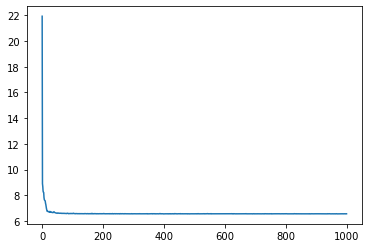

FOLD 801
train [28.956287384033203, 6.551865577697754]
val [31.72244644165039, 6.741887092590332]
predict val...
predict test...
137.5272 242.81474
125.70154 242.81474 415.3042 1.0
FOLD 802
train [29.035207748413086, 6.557295322418213]
val [29.99692726135254, 6.595065116882324]
predict val...
predict test...
124.251434 248.84456
140.40271 248.84456 421.6919 1.0
FOLD 803
train [27.892864227294922, 6.503060817718506]
val [35.72216033935547, 6.6810808181762695]
predict val...
predict test...
155.15399 233.14482
108.59009 233.14482 509.77246 1.0
FOLD 804
train [29.996164321899414, 6.596031188964844]
val [28.73252296447754, 6.492397785186768]
predict val...
predict test...
125.13615 225.98035
90.52496 225.98035 380.49902 1.0
FOLD 805
train [29.429183959960938, 6.555399417877197]
val [32.23945617675781, 6.658416748046875]
predict val...
predict test...
140.64526 221.41887
113.09857 221.41887 376.65332 1.0
FOLD 806
train [29.006813049316406, 6.557372093200684]
val [32.23204803466797, 6.774512

train [28.250638961791992, 6.522948265075684]
val [31.45453453063965, 6.672764778137207]
predict val...
predict test...
133.22412 240.47241
136.53503 240.47241 329.0078 1.0
FOLD 848
train [27.284542083740234, 6.474159240722656]
val [36.34184265136719, 6.658877372741699]
predict val...
predict test...
157.7155 233.68593
139.84229 233.68593 368.79565 1.0
FOLD 849
train [28.846426010131836, 6.550070762634277]
val [29.643583297729492, 6.484647274017334]
predict val...
predict test...
130.67496 235.753
140.01587 235.753 286.77173 1.0
FOLD 850
train [27.892026901245117, 6.521609306335449]
val [35.15978240966797, 6.741332054138184]
predict val...
predict test...
153.72467 230.40854
127.601074 230.40854 323.5227 1.0
FOLD 851
train [33.601715087890625, 6.558865547180176]
val [37.29555892944336, 6.766176223754883]
predict val...
predict test...
139.34973 244.70256
118.87195 244.70256 425.1748 1.0
FOLD 852
train [33.830806732177734, 6.5630927085876465]
val [35.0976448059082, 6.6278300285339355]
p

train [30.355831146240234, 6.455271244049072]
val [45.05994415283203, 6.778236389160156]
predict val...
predict test...
166.1561 225.19153
72.428955 225.19153 281.12036 1.0
FOLD 894
train [34.50934982299805, 6.5980544090271]
val [30.985294342041016, 6.482782363891602]
predict val...
predict test...
120.253204 237.29825
148.18433 237.29825 333.29395 1.0
FOLD 895
train [32.75980758666992, 6.540173530578613]
val [38.22873306274414, 6.67960262298584]
predict val...
predict test...
143.77983 233.8162
164.63611 233.8162 326.41772 1.0
FOLD 896
train [33.114742279052734, 6.54458475112915]
val [37.182525634765625, 6.782846450805664]
predict val...
predict test...
139.18048 245.58247
171.9834 245.58247 330.64062 1.0
FOLD 897
train [33.35725784301758, 6.560196876525879]
val [35.17277908325195, 6.620431423187256]
predict val...
predict test...
127.90587 247.66885
160.9751 247.66885 381.16943 1.0
FOLD 898
train [31.422571182250977, 6.479159355163574]
val [42.409454345703125, 6.6609015464782715]
pre

train [36.714813232421875, 6.520773410797119]
val [37.689453125, 6.437827110290527]
predict val...
predict test...
123.93924 219.45023
127.467285 219.45023 284.44385 1.0
FOLD 940
train [36.021331787109375, 6.513493537902832]
val [49.8554573059082, 6.7682647705078125]
predict val...
predict test...
163.16496 231.22507
172.96094 231.22507 291.6333 1.0
FOLD 941
train [36.2227783203125, 6.5140180587768555]
val [40.44072341918945, 6.652132034301758]
predict val...
predict test...
133.27948 243.16719
149.96753 243.16719 316.7583 1.0
FOLD 942
train [38.04483413696289, 6.567831993103027]
val [39.2874641418457, 6.617570877075195]
predict val...
predict test...
125.54552 251.9489
150.53137 251.9489 397.05566 1.0
FOLD 943
train [35.31990051269531, 6.47802734375]
val [48.61103057861328, 6.669157981872559]
predict val...
predict test...
158.1416 229.25743
151.03662 229.25743 316.28564 1.0
FOLD 944
train [37.8488655090332, 6.562904357910156]
val [37.084014892578125, 6.507586479187012]
predict val...

train [41.634620666503906, 6.542043209075928]
val [49.69011306762695, 6.684561729431152]
predict val...
predict test...
147.81963 238.67107
150.28271 238.67107 343.3794 1.0
FOLD 986
train [39.943763732910156, 6.508848667144775]
val [45.705162048339844, 6.722701072692871]
predict val...
predict test...
133.88246 245.04851
101.39331 245.04851 339.19287 1.0
FOLD 987
train [42.58790969848633, 6.572421073913574]
val [43.01298141479492, 6.582217216491699]
predict val...
predict test...
122.31802 256.2565
166.70337 256.2565 395.8379 1.0
FOLD 988
train [39.77832794189453, 6.490384578704834]
val [54.3885383605957, 6.674728870391846]
predict val...
predict test...
158.08728 230.51901
147.38184 230.51901 377.5952 1.0
FOLD 989
train [43.23812484741211, 6.580508232116699]
val [41.695770263671875, 6.492982387542725]
predict val...
predict test...
124.245674 230.50249
123.63971 230.50249 338.354 1.0
FOLD 990
train [41.798553466796875, 6.5518479347229]
val [49.06913375854492, 6.681661605834961]
predic

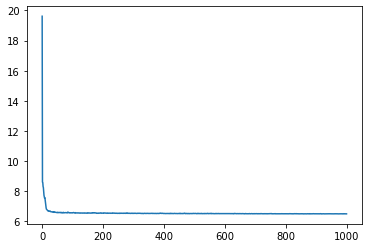

FOLD 1001
train [29.116840362548828, 6.5682220458984375]
val [32.20233154296875, 6.7561492919921875]
predict val...
predict test...
139.83052 252.25221
123.06616 252.25221 439.7378 1.0
FOLD 1002
train [29.179296493530273, 6.560159206390381]
val [30.214344024658203, 6.6014556884765625]
predict val...
predict test...
125.26943 247.2832
126.46106 247.2832 427.6665 1.0
FOLD 1003
train [27.753005981445312, 6.499045372009277]
val [35.25667190551758, 6.666816711425781]
predict val...
predict test...
153.80943 232.04768
106.38013 232.04768 519.1284 1.0
FOLD 1004
train [30.091888427734375, 6.60198450088501]
val [29.265010833740234, 6.5128583908081055]
predict val...
predict test...
127.687614 228.30563
91.321655 228.30563 382.3296 1.0
FOLD 1005
train [27.764949798583984, 6.504611015319824]
val [31.89414405822754, 6.669986724853516]
predict val...
predict test...
138.46558 214.5686
113.76965 214.5686 360.22363 1.0
FOLD 1006
train [28.639511108398438, 6.546311855316162]
val [31.896604537963867, 6

train [27.295764923095703, 6.4890456199646]
val [33.15509033203125, 6.788025856018066]
predict val...
predict test...
143.24269 237.5574
126.46069 237.5574 331.00244 1.0
FOLD 1047
train [28.757970809936523, 6.5491943359375]
val [30.53379249572754, 6.6406049728393555]
predict val...
predict test...
129.45584 243.52846
168.36633 243.52846 356.66455 1.0
FOLD 1048
train [27.3880615234375, 6.499169826507568]
val [37.15852737426758, 6.683462142944336]
predict val...
predict test...
160.34172 235.34532
157.35461 235.34532 334.9629 1.0
FOLD 1049
train [28.818883895874023, 6.5542192459106445]
val [29.11503028869629, 6.499669551849365]
predict val...
predict test...
127.49514 232.41089
161.88354 232.41089 283.6001 1.0
FOLD 1050
train [27.447265625, 6.491527557373047]
val [34.774654388427734, 6.7903642654418945]
predict val...
predict test...
151.5556 226.01277
67.83057 226.01277 346.86572 1.0
FOLD 1051
train [33.40769577026367, 6.556955814361572]
val [37.15032196044922, 6.753329277038574]
predic

train [32.86677932739258, 6.540387153625488]
val [36.84626770019531, 6.765270233154297]
predict val...
predict test...
138.71098 247.26659
161.16064 247.26659 338.23535 1.0
FOLD 1092
train [33.35295486450195, 6.559006690979004]
val [34.591251373291016, 6.597104072570801]
predict val...
predict test...
125.652534 250.4219
167.28162 250.4219 383.25 1.0
FOLD 1093
train [29.47467041015625, 6.41070556640625]
val [44.667236328125, 6.693788528442383]
predict val...
predict test...
164.69444 216.24231
118.15845 216.24231 283.18457 1.0
FOLD 1094
train [33.97645568847656, 6.581839561462402]
val [31.761133193969727, 6.475931167602539]
predict val...
predict test...
120.642586 230.57877
134.60516 230.57877 312.43408 1.0
FOLD 1095
train [32.12986755371094, 6.521146297454834]
val [38.26905822753906, 6.712197780609131]
predict val...
predict test...
142.8764 236.21982
89.08057 236.21982 327.82593 1.0
FOLD 1096
train [31.92885971069336, 6.513158321380615]
val [35.59054183959961, 6.600554466247559]
pre

train [37.25074005126953, 6.539231300354004]
val [42.31806182861328, 6.783992767333984]
predict val...
predict test...
139.54576 249.72583
166.9541 249.72583 350.75488 1.0
FOLD 1137
train [36.343536376953125, 6.510814666748047]
val [39.148406982421875, 6.60097599029541]
predict val...
predict test...
128.4704 231.29222
167.42432 231.29222 296.00635 1.0
FOLD 1138
train [35.64502716064453, 6.484123229980469]
val [48.804813385009766, 6.675926685333252]
predict val...
predict test...
159.47984 231.05598
163.98328 231.05598 280.49316 1.0
FOLD 1139
train [37.2049674987793, 6.532063961029053]
val [36.993709564208984, 6.481757640838623]
predict val...
predict test...
123.399796 232.56967
67.94531 232.56967 328.20557 1.0
FOLD 1140
train [36.203617095947266, 6.519551753997803]
val [45.28647994995117, 6.711282730102539]
predict val...
predict test...
149.51784 229.00618
150.25293 229.00618 312.64966 1.0
FOLD 1141
train [36.41845703125, 6.51868200302124]
val [42.48625564575195, 6.7840142250061035]

train [41.06950378417969, 6.523568630218506]
val [49.231075286865234, 6.802934646606445]
predict val...
predict test...
144.86925 246.4757
149.38123 246.4757 332.03027 1.0
FOLD 1182
train [41.69744873046875, 6.543122291564941]
val [44.2255973815918, 6.632079124450684]
predict val...
predict test...
127.1532 247.09866
155.15552 247.09866 394.09082 1.0
FOLD 1183
train [39.20229721069336, 6.468814849853516]
val [54.921104431152344, 6.684816360473633]
predict val...
predict test...
158.71404 225.30595
130.63916 225.30595 295.19556 1.0
FOLD 1184
train [42.954132080078125, 6.567112922668457]
val [42.21501922607422, 6.490286350250244]
predict val...
predict test...
127.0722 233.8639
134.19763 233.8639 307.6455 1.0
FOLD 1185
train [39.72875213623047, 6.510611534118652]
val [47.1380729675293, 6.675144195556641]
predict val...
predict test...
140.03555 231.08957
168.0 231.08957 297.71533 1.0
FOLD 1186
train [41.51883316040039, 6.537154197692871]
val [47.42927169799805, 6.77122688293457]
predict 

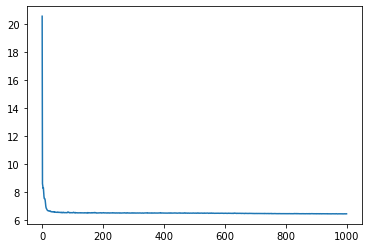

FOLD 1201
train [28.9132137298584, 6.552004337310791]
val [31.775854110717773, 6.74070930480957]
predict val...
predict test...
137.85408 242.69482
120.52161 242.69482 417.66992 1.0
FOLD 1202
train [29.301063537597656, 6.565041542053223]
val [29.791200637817383, 6.588005542755127]
predict val...
predict test...
122.88811 250.3636
126.82898 250.3636 434.91504 1.0
FOLD 1203
train [27.783504486083984, 6.494719505310059]
val [35.86634826660156, 6.675253868103027]
predict val...
predict test...
155.72781 225.41547
121.45227 225.41547 447.94238 1.0
FOLD 1204
train [29.986255645751953, 6.602447509765625]
val [29.020732879638672, 6.5101399421691895]
predict val...
predict test...
127.2322 234.02005
94.431885 234.02005 386.16504 1.0
FOLD 1205
train [28.930126190185547, 6.5433759689331055]
val [31.779891967773438, 6.6358842849731445]
predict val...
predict test...
139.01277 225.9027
108.98132 225.9027 375.5005 1.0
FOLD 1206
train [28.49199676513672, 6.545261383056641]
val [33.09014129638672, 6.8

train [27.710803985595703, 6.5083417892456055]
val [30.21788787841797, 6.619007110595703]
predict val...
predict test...
130.41753 239.56981
163.71387 239.56981 309.292 1.0
FOLD 1247
train [27.81486701965332, 6.51708459854126]
val [30.250957489013672, 6.606531143188477]
predict val...
predict test...
127.83599 236.22557
124.34839 236.22557 328.51025 1.0
FOLD 1248
train [26.640666961669922, 6.452287197113037]
val [36.844791412353516, 6.694671154022217]
predict val...
predict test...
158.96532 222.52203
100.20154 222.52203 315.15063 1.0
FOLD 1249
train [28.87469482421875, 6.565410614013672]
val [28.87143325805664, 6.519400596618652]
predict val...
predict test...
127.2826 239.0362
167.10431 239.0362 287.51807 1.0
FOLD 1250
train [27.25035285949707, 6.478281497955322]
val [33.55289077758789, 6.7860307693481445]
predict val...
predict test...
146.48393 228.53151
64.77344 228.53151 368.0835 1.0
FOLD 1251
train [33.41282272338867, 6.5526556968688965]
val [36.833839416503906, 6.74413299560546

train [32.28079605102539, 6.516172885894775]
val [38.647422790527344, 6.817876815795898]
predict val...
predict test...
144.255 240.5825
122.949585 240.5825 345.5913 1.0
FOLD 1292
train [30.95816421508789, 6.484169960021973]
val [34.82075119018555, 6.545803070068359]
predict val...
predict test...
127.30665 230.23326
162.3772 230.23326 293.73828 1.0
FOLD 1293
train [31.37706184387207, 6.485204219818115]
val [41.80658721923828, 6.662371635437012]
predict val...
predict test...
154.17033 236.85858
157.18726 236.85858 308.9944 1.0
FOLD 1294
train [34.16815185546875, 6.581734657287598]
val [31.80622673034668, 6.490123748779297]
predict val...
predict test...
121.04912 242.65584
157.9552 242.65584 353.8108 1.0
FOLD 1295
train [31.44427490234375, 6.497544765472412]
val [39.09304428100586, 6.697986602783203]
predict val...
predict test...
146.12566 227.08014
142.14941 227.08014 334.34106 1.0
FOLD 1296
train [32.73246383666992, 6.529661655426025]
val [37.277427673339844, 6.790865898132324]
pre

train [36.8911018371582, 6.5301947593688965]
val [42.661376953125, 6.7906036376953125]
predict val...
predict test...
140.2938 246.5514
130.38354 246.5514 397.1289 1.0
FOLD 1337
train [37.64990234375, 6.556615352630615]
val [39.248748779296875, 6.611466407775879]
predict val...
predict test...
127.02437 253.50987
172.24646 253.50987 356.49512 1.0
FOLD 1338
train [34.030799865722656, 6.439947605133057]
val [50.286537170410156, 6.71138334274292]
predict val...
predict test...
163.51291 220.13564
129.30151 220.13564 306.489 1.0
FOLD 1339
train [36.00171661376953, 6.512310981750488]
val [34.8880500793457, 6.407036781311035]
predict val...
predict test...
116.26932 226.68175
120.29883 226.68175 321.50208 1.0
FOLD 1340
train [35.24428176879883, 6.488802909851074]
val [44.05624771118164, 6.77531623840332]
predict val...
predict test...
144.72847 229.4373
43.856445 229.4373 322.80127 1.0
FOLD 1341
train [36.96245193481445, 6.534539699554443]
val [41.85039138793945, 6.734494686126709]
predict v

train [39.80879211425781, 6.498028755187988]
val [48.679325103759766, 6.808487892150879]
predict val...
predict test...
142.96631 241.76628
146.50732 241.76628 322.1587 1.0
FOLD 1382
train [41.223751068115234, 6.539096832275391]
val [57.99578857421875, 7.113092422485352]
predict val...
predict test...
161.59085 244.66124
156.745 244.66124 393.19922 1.0
FOLD 1383
train [38.21390151977539, 6.459805965423584]
val [56.939064025878906, 6.752270221710205]
predict val...
predict test...
165.35666 228.528
89.85425 228.528 300.8335 1.0
FOLD 1384
train [42.177955627441406, 6.5514817237854]
val [42.338748931884766, 6.457853317260742]
predict val...
predict test...
125.29032 229.62938
116.270325 229.62938 313.07007 1.0
FOLD 1385
train [40.5580940246582, 6.511103630065918]
val [48.3012580871582, 6.698324203491211]
predict val...
predict test...
144.11562 242.44136
132.30786 242.44136 390.12305 1.0
FOLD 1386
train [40.31599044799805, 6.510875701904297]
val [44.918521881103516, 6.608814239501953]
pre

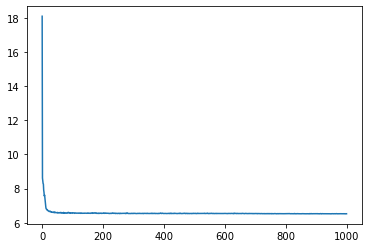

FOLD 1401
train [28.877696990966797, 6.5546464920043945]
val [31.788314819335938, 6.724989414215088]
predict val...
predict test...
138.02422 245.56468
119.92297 245.56468 425.208 1.0
FOLD 1402
train [29.222427368164062, 6.559187412261963]
val [30.183292388916016, 6.602057456970215]
predict val...
predict test...
125.025604 245.3383
129.07178 245.3383 420.12842 1.0
FOLD 1403
train [27.64826202392578, 6.487248420715332]
val [36.13697814941406, 6.6899237632751465]
predict val...
predict test...
156.24965 223.66173
111.05969 223.66173 466.22314 1.0
FOLD 1404
train [30.116329193115234, 6.607896327972412]
val [28.51020050048828, 6.5041961669921875]
predict val...
predict test...
124.371284 233.93338
97.83118 233.93338 381.50684 1.0
FOLD 1405
train [28.70399284362793, 6.5319976806640625]
val [32.6281623840332, 6.648982048034668]
predict val...
predict test...
142.54466 224.05031
118.35242 224.05031 355.32275 1.0
FOLD 1406
train [28.545717239379883, 6.545891761779785]
val [32.61197280883789, 

train [27.6417293548584, 6.486181735992432]
val [32.64091491699219, 6.879189491271973]
predict val...
predict test...
139.8841 228.57904
-0.2109375 228.57904 468.2163 0.996742671009772
FOLD 1447
train [28.072826385498047, 6.531867980957031]
val [30.687185287475586, 6.569732666015625]
predict val...
predict test...
130.07779 239.50275
160.01453 239.50275 335.63477 1.0
FOLD 1448
train [26.133853912353516, 6.420326232910156]
val [35.32430648803711, 6.641861915588379]
predict val...
predict test...
151.86078 212.66173
112.69092 212.66173 282.71948 1.0
FOLD 1449
train [28.92881965637207, 6.563051700592041]
val [28.78011703491211, 6.510517120361328]
predict val...
predict test...
128.10063 233.44856
160.65845 233.44856 298.64014 1.0
FOLD 1450
train [27.21319007873535, 6.485407829284668]
val [33.722686767578125, 6.798831939697266]
predict val...
predict test...
145.40825 231.13583
7.659912 231.13583 385.2068 1.0
FOLD 1451
train [33.46430206298828, 6.561061859130859]
val [36.97032165527344, 6.

train [31.701980590820312, 6.492239952087402]
val [37.60081100463867, 6.816336631774902]
predict val...
predict test...
139.64848 231.88335
106.07373 231.88335 382.26367 1.0
FOLD 1492
train [32.1107177734375, 6.51653528213501]
val [37.398014068603516, 6.741379737854004]
predict val...
predict test...
139.30533 249.4675
150.42908 249.4675 372.76807 1.0
FOLD 1493
train [31.315502166748047, 6.477182865142822]
val [42.649662017822266, 6.674487113952637]
predict val...
predict test...
158.79791 233.84294
127.62097 233.84294 307.82373 1.0
FOLD 1494
train [31.262624740600586, 6.492759704589844]
val [33.022621154785156, 6.476849555969238]
predict val...
predict test...
124.3548 227.7245
68.71582 227.7245 291.57422 1.0
FOLD 1495
train [31.624361038208008, 6.491811275482178]
val [40.2166862487793, 6.835165023803711]
predict val...
predict test...
150.71608 230.47339
13.506348 230.47339 421.12988 1.0
FOLD 1496
train [31.47368621826172, 6.4853105545043945]
val [37.30722427368164, 6.876983165740967

train [36.944183349609375, 6.530686855316162]
val [42.33378219604492, 6.792154788970947]
predict val...
predict test...
139.42126 241.66878
143.78442 241.66878 334.23706 1.0
FOLD 1537
train [37.18193817138672, 6.550797939300537]
val [39.63068771362305, 6.596343040466309]
predict val...
predict test...
126.89169 248.44498
174.54285 248.44498 364.71045 1.0
FOLD 1538
train [35.75901412963867, 6.488163948059082]
val [49.92571258544922, 6.6822509765625]
predict val...
predict test...
162.2104 232.78496
152.5149 232.78496 296.2661 1.0
FOLD 1539
train [38.650962829589844, 6.5711350440979]
val [36.90438461303711, 6.488641738891602]
predict val...
predict test...
124.2589 231.69661
141.97571 231.69661 307.6792 1.0
FOLD 1540
train [35.3513069152832, 6.487656593322754]
val [42.55529022216797, 6.705995559692383]
predict val...
predict test...
140.64671 229.24927
84.10889 229.24927 311.74658 1.0
FOLD 1541
train [34.872379302978516, 6.473488807678223]
val [39.816287994384766, 6.557403564453125]
pred

train [41.66191864013672, 6.547392845153809]
val [47.16461181640625, 6.744616508483887]
predict val...
predict test...
139.12834 255.82706
163.33691 255.82706 344.40332 1.0
FOLD 1582
train [41.515480041503906, 6.539585113525391]
val [44.40576934814453, 6.63056755065918]
predict val...
predict test...
127.515434 245.79947
159.11255 245.79947 384.60498 1.0
FOLD 1583
train [38.33953857421875, 6.451912879943848]
val [55.434146881103516, 6.695674896240234]
predict val...
predict test...
160.00377 229.11546
129.55322 229.11546 310.15283 1.0
FOLD 1584
train [42.99165344238281, 6.587180137634277]
val [41.03948974609375, 6.485852241516113]
predict val...
predict test...
125.27292 236.06699
152.22693 236.06699 321.47217 1.0
FOLD 1585
train [40.17961883544922, 6.49749755859375]
val [51.004852294921875, 6.793404579162598]
predict val...
predict test...
150.38232 235.20453
39.15576 235.20453 370.05872 1.0
FOLD 1586
train [39.81644058227539, 6.503498077392578]
val [44.291725158691406, 6.535831451416

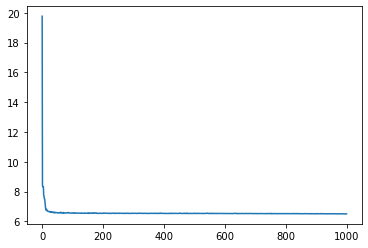

FOLD 1601
train [29.09554672241211, 6.558140754699707]
val [31.882911682128906, 6.749424934387207]
predict val...
predict test...
138.01285 243.52515
118.22217 243.52515 423.85156 1.0
FOLD 1602
train [29.11680030822754, 6.554746150970459]
val [29.572864532470703, 6.578397274017334]
predict val...
predict test...
122.74672 241.62032
139.35095 241.62032 404.14795 1.0
FOLD 1603
train [27.764347076416016, 6.4949140548706055]
val [35.84280776977539, 6.670628547668457]
predict val...
predict test...
154.4032 226.53323
133.67554 226.53323 384.54785 1.0
FOLD 1604
train [29.946794509887695, 6.6019182205200195]
val [29.26881217956543, 6.512923717498779]
predict val...
predict test...
127.722275 233.0282
94.14276 233.0282 385.5498 1.0
FOLD 1605
train [28.36894416809082, 6.524861812591553]
val [32.87200927734375, 6.667133808135986]
predict val...
predict test...
143.57756 221.46396
122.16333 221.46396 351.81934 1.0
FOLD 1606
train [28.413043975830078, 6.546451568603516]
val [32.43666458129883, 6.7

train [26.1258487701416, 6.452471733093262]
val [30.15543556213379, 6.565322399139404]
predict val...
predict test...
129.1974 226.76573
126.55176 226.76573 289.68994 1.0
FOLD 1647
train [28.090158462524414, 6.522883415222168]
val [30.050628662109375, 6.541067123413086]
predict val...
predict test...
128.13934 242.38164
140.32214 242.38164 330.00342 1.0
FOLD 1648
train [25.99022102355957, 6.406493186950684]
val [36.225589752197266, 6.701535224914551]
predict val...
predict test...
155.90038 210.90637
59.99414 210.90637 315.25 1.0
FOLD 1649
train [28.71791648864746, 6.554293632507324]
val [27.524791717529297, 6.487452507019043]
predict val...
predict test...
120.15116 244.84622
107.701904 244.84622 400.0337 1.0
FOLD 1650
train [26.967235565185547, 6.460801601409912]
val [33.57652282714844, 6.788131237030029]
predict val...
predict test...
143.33975 243.99445
90.77612 243.99445 584.10693 1.0
FOLD 1651
train [33.304203033447266, 6.557913303375244]
val [37.49884796142578, 6.77531623840332]

train [30.799427032470703, 6.471972465515137]
val [37.122188568115234, 6.7532196044921875]
predict val...
predict test...
136.98155 231.10251
78.44165 231.10251 367.3877 1.0
FOLD 1692
train [33.28466796875, 6.5513739585876465]
val [34.84676742553711, 6.619302749633789]
predict val...
predict test...
126.560875 245.23354
163.22144 245.23354 386.44775 1.0
FOLD 1693
train [28.624048233032227, 6.387317180633545]
val [44.91830062866211, 6.714998722076416]
predict val...
predict test...
165.30894 211.69545
63.83191 211.69545 300.34253 1.0
FOLD 1694
train [31.575956344604492, 6.49838924407959]
val [31.38968276977539, 6.405426979064941]
predict val...
predict test...
118.85528 224.82808
53.159912 224.82808 301.54492 1.0
FOLD 1695
train [31.309803009033203, 6.483786106109619]
val [40.27942657470703, 6.779481887817383]
predict val...
predict test...
150.33168 236.66006
58.816406 236.66006 352.7788 1.0
FOLD 1696
train [32.19857406616211, 6.49709415435791]
val [37.050254821777344, 6.79242801666259

train [34.584014892578125, 6.462063789367676]
val [44.49241638183594, 7.071627616882324]
predict val...
predict test...
142.8104 219.68747
60.168457 219.68747 363.4568 1.0
FOLD 1737
train [35.15238571166992, 6.48201847076416]
val [41.022796630859375, 6.772239685058594]
predict val...
predict test...
132.52808 226.64836
91.06128 226.64836 277.34082 1.0
FOLD 1738
train [35.67457580566406, 6.478674411773682]
val [48.40576171875, 6.659619331359863]
predict val...
predict test...
157.962 227.0752
141.5841 227.0752 285.2705 1.0
FOLD 1739
train [38.306419372558594, 6.562312126159668]
val [36.197731018066406, 6.500119686126709]
predict val...
predict test...
121.92035 239.99786
140.92883 239.99786 319.3496 1.0
FOLD 1740
train [34.486595153808594, 6.449342250823975]
val [41.415401458740234, 6.7072601318359375]
predict val...
predict test...
136.1566 227.8124
62.953613 227.8124 354.156 1.0
FOLD 1741
train [36.065704345703125, 6.494260311126709]
val [42.48753356933594, 6.8726091384887695]
predict

train [41.64704895019531, 6.5428147315979]
val [47.18107604980469, 6.788027763366699]
predict val...
predict test...
138.80382 251.84685
166.35852 251.84685 347.28955 1.0
FOLD 1782
train [39.67332077026367, 6.483296871185303]
val [44.575111389160156, 6.612504005432129]
predict val...
predict test...
129.53677 223.79507
161.78662 223.79507 289.39844 1.0
FOLD 1783
train [36.11944580078125, 6.3839430809021]
val [55.87662124633789, 6.712399005889893]
predict val...
predict test...
159.76009 203.1145
95.12756 203.1145 272.77246 1.0
FOLD 1784
train [40.28728485107422, 6.4992356300354]
val [40.170310974121094, 6.4555816650390625]
predict val...
predict test...
119.82841 227.29901
80.20654 227.29901 322.22778 1.0
FOLD 1785
train [40.47490692138672, 6.5301513671875]
val [51.25374221801758, 6.744585037231445]
predict val...
predict test...
151.64793 237.41817
170.02795 237.41817 324.0774 1.0
FOLD 1786
train [40.051185607910156, 6.505196571350098]
val [46.5439453125, 6.688618183135986]
predict va

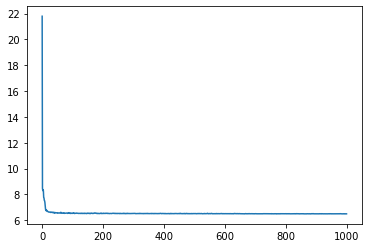

FOLD 1801
train [28.869844436645508, 6.547556400299072]
val [31.99428367614746, 6.737257480621338]
predict val...
predict test...
138.67479 241.75815
138.32544 241.75815 381.1958 1.0
FOLD 1802
train [28.781740188598633, 6.542751312255859]
val [29.727275848388672, 6.578729629516602]
predict val...
predict test...
123.31366 240.21529
136.89929 240.21529 401.896 1.0
FOLD 1803
train [27.842145919799805, 6.5003156661987305]
val [35.466976165771484, 6.67132043838501]
predict val...
predict test...
154.00317 231.32466
116.013794 231.32466 486.30127 1.0
FOLD 1804
train [29.65568733215332, 6.613668918609619]
val [27.94300651550293, 6.5126471519470215]
predict val...
predict test...
122.536224 251.59311
118.35809 251.59311 389.36768 1.0
FOLD 1805
train [27.99135398864746, 6.523573398590088]
val [32.45045471191406, 6.683019638061523]
predict val...
predict test...
143.26993 228.87355
126.24524 228.87355 348.96045 1.0
FOLD 1806
train [27.41668128967285, 6.509110927581787]
val [31.697818756103516, 

train [27.177339553833008, 6.47968053817749]
val [31.691539764404297, 6.667067050933838]
predict val...
predict test...
136.21527 224.27255
-17.495605 224.27255 373.25684 0.993485342019544
FOLD 1847
train [27.377391815185547, 6.483758449554443]
val [29.728233337402344, 6.5592193603515625]
predict val...
predict test...
127.317474 243.44737
117.8916 243.44737 416.09912 1.0
FOLD 1848
train [27.031293869018555, 6.459046840667725]
val [36.9731559753418, 6.658288955688477]
predict val...
predict test...
159.57051 222.85902
134.21228 222.85902 352.2683 1.0
FOLD 1849
train [28.92862892150879, 6.563875675201416]
val [27.79804229736328, 6.482751846313477]
predict val...
predict test...
120.0782 244.97897
134.08862 244.97897 333.20312 1.0
FOLD 1850
train [27.510637283325195, 6.4906721115112305]
val [32.34743881225586, 6.721844673156738]
predict val...
predict test...
138.56354 226.1874
-1.9589844 226.1874 397.00098 0.996742671009772
FOLD 1851
train [33.266029357910156, 6.558968544006348]
val [36

train [30.3592472076416, 6.445200443267822]
val [36.016807556152344, 6.631760597229004]
predict val...
predict test...
132.26582 218.73048
88.97876 218.73048 342.14624 1.0
FOLD 1892
train [30.983579635620117, 6.479037284851074]
val [35.661949157714844, 6.640228271484375]
predict val...
predict test...
133.58759 231.19608
155.43103 231.19608 293.7224 1.0
FOLD 1893
train [28.357173919677734, 6.365813255310059]
val [42.27914810180664, 6.6557817459106445]
predict val...
predict test...
154.67278 212.66821
87.99341 212.66821 320.88892 1.0
FOLD 1894
train [32.71251678466797, 6.533900260925293]
val [32.953704833984375, 6.533360958099365]
predict val...
predict test...
125.05749 237.86838
74.28833 237.86838 320.50366 1.0
FOLD 1895
train [31.40118980407715, 6.492364406585693]
val [48.34233474731445, 7.156120300292969]
predict val...
predict test...
178.43309 222.81609
-56.10205 222.81609 345.99756 0.9609120521172638
FOLD 1896
train [30.200780868530273, 6.446600914001465]
val [33.59416198730469,

train [36.67270278930664, 6.525881290435791]
val [41.27177047729492, 6.715706825256348]
predict val...
predict test...
135.29185 249.57428
151.71826 249.57428 342.12598 1.0
FOLD 1937
train [37.168670654296875, 6.549307823181152]
val [39.77714157104492, 6.58119010925293]
predict val...
predict test...
128.004 249.12051
164.91321 249.12051 371.18213 1.0
FOLD 1938
train [35.083431243896484, 6.467909812927246]
val [50.50642013549805, 6.712654113769531]
predict val...
predict test...
164.40016 223.70807
118.194824 223.70807 284.87476 1.0
FOLD 1939
train [37.21392059326172, 6.5205278396606445]
val [36.21634292602539, 6.486804008483887]
predict val...
predict test...
121.74125 242.02824
19.93457 242.02824 396.6499 1.0
FOLD 1940
train [36.06764221191406, 6.513857841491699]
val [46.46955108642578, 6.74740743637085]
predict val...
predict test...
155.0398 234.5898
171.41846 234.5898 313.06348 1.0
FOLD 1941
train [36.61970520019531, 6.508077144622803]
val [43.11003875732422, 6.94610071182251]
pre

train [39.00349807739258, 6.4861159324646]
val [48.98538589477539, 6.8202128410339355]
predict val...
predict test...
142.89714 237.91035
112.864746 237.91035 334.82422 1.0
FOLD 1982
train [41.42902374267578, 6.541454315185547]
val [44.45631408691406, 6.616892337799072]
predict val...
predict test...
129.20961 250.97911
161.7002 250.97911 370.53955 1.0
FOLD 1983
train [39.688255310058594, 6.47980260848999]
val [54.18135452270508, 6.661965370178223]
predict val...
predict test...
157.39238 232.51726
149.79822 232.51726 322.66724 1.0
FOLD 1984
train [41.35841369628906, 6.5349578857421875]
val [40.991554260253906, 6.453919410705566]
predict val...
predict test...
120.823166 237.37918
88.11719 237.37918 329.73828 1.0
FOLD 1985
train [40.196807861328125, 6.515563011169434]
val [48.20138168334961, 6.729862689971924]
predict val...
predict test...
142.34193 238.41333
86.703125 238.41333 320.01392 1.0
FOLD 1986
train [40.934715270996094, 6.52011775970459]
val [46.954345703125, 6.76547622680664

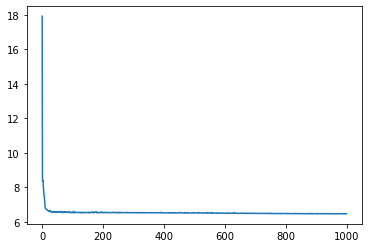

FOLD 2001
train [28.573862075805664, 6.5411057472229]
val [31.666912078857422, 6.735123157501221]
predict val...
predict test...
137.66667 245.56566
144.50903 245.56566 373.86328 1.0
FOLD 2002
train [29.301481246948242, 6.570613861083984]
val [29.289587020874023, 6.576027870178223]
predict val...
predict test...
121.79876 247.22246
149.14807 247.22246 407.27344 1.0
FOLD 2003
train [27.81003761291504, 6.495179653167725]
val [36.23601531982422, 6.679059028625488]
predict val...
predict test...
157.94621 227.28537
112.93909 227.28537 480.57812 1.0
FOLD 2004
train [30.012752532958984, 6.606241703033447]
val [29.118497848510742, 6.513971328735352]
predict val...
predict test...
126.85269 235.2006
93.8949 235.2006 395.104 1.0
FOLD 2005
train [28.453754425048828, 6.550945281982422]
val [32.94591522216797, 6.680078029632568]
predict val...
predict test...
144.00542 246.68654
154.2091 246.68654 359.72363 1.0
FOLD 2006
train [28.748760223388672, 6.552615165710449]
val [31.24363136291504, 6.72335

train [27.777204513549805, 6.492079734802246]
val [33.319969177246094, 7.000439643859863]
predict val...
predict test...
143.39355 229.27194
60.919434 229.27194 489.5078 1.0
FOLD 2047
train [27.108163833618164, 6.488990783691406]
val [31.35385513305664, 6.600017070770264]
predict val...
predict test...
133.44978 235.33301
151.84619 235.33301 326.2378 1.0
FOLD 2048
train [24.567920684814453, 6.353325366973877]
val [37.483009338378906, 6.703444480895996]
predict val...
predict test...
159.51604 198.08818
63.856567 198.08818 288.94653 1.0
FOLD 2049
train [26.65284538269043, 6.466709136962891]
val [28.75551986694336, 6.491412162780762]
predict val...
predict test...
124.85983 224.42058
69.70679 224.42058 321.55737 1.0
FOLD 2050
train [26.474288940429688, 6.439140319824219]
val [32.55504608154297, 6.733829498291016]
predict val...
predict test...
141.20715 236.50784
82.78076 236.50784 523.8694 1.0
FOLD 2051
train [33.539798736572266, 6.56435489654541]
val [37.01033020019531, 6.7306346893310

train [30.953487396240234, 6.477329254150391]
val [37.88029479980469, 6.7538042068481445]
predict val...
predict test...
141.14467 234.53568
114.37549 234.53568 366.17725 1.0
FOLD 2092
train [32.02439498901367, 6.5080413818359375]
val [34.77741622924805, 6.598063945770264]
predict val...
predict test...
127.55756 245.54723
147.23389 245.54723 346.7036 1.0
FOLD 2093
train [27.937856674194336, 6.346050262451172]
val [42.791412353515625, 6.685613632202148]
predict val...
predict test...
155.59854 204.205
82.78552 204.205 295.09595 1.0
FOLD 2094
train [32.07817840576172, 6.506031036376953]
val [31.903526306152344, 6.453035354614258]
predict val...
predict test...
119.983345 233.93655
42.74121 233.93655 378.72656 1.0
FOLD 2095
train [30.88768196105957, 6.471304416656494]
val [38.36151123046875, 6.759063243865967]
predict val...
predict test...
145.56366 229.06383
-1.2231445 229.06383 322.28345 0.993485342019544
FOLD 2096
train [31.4223690032959, 6.4806108474731445]
val [38.842491149902344, 

train [36.59209060668945, 6.520974636077881]
val [42.93463897705078, 6.759773254394531]
predict val...
predict test...
141.68132 244.7122
133.3523 244.7122 333.7246 1.0
FOLD 2137
train [35.17070770263672, 6.491052150726318]
val [40.148921966552734, 6.546173095703125]
predict val...
predict test...
130.21326 234.14473
156.8512 234.14473 288.87866 1.0
FOLD 2138
train [33.03204345703125, 6.407240390777588]
val [51.4511604309082, 6.667695999145508]
predict val...
predict test...
166.18752 229.66086
72.39038 229.66086 356.0537 1.0
FOLD 2139
train [35.85342025756836, 6.504205226898193]
val [36.26536560058594, 6.484742164611816]
predict val...
predict test...
121.83258 235.37994
117.980225 235.37994 338.97607 1.0
FOLD 2140
train [36.05850601196289, 6.505962371826172]
val [45.87663269042969, 6.763617515563965]
predict val...
predict test...
150.77904 231.45663
94.04492 231.45663 325.37817 1.0
FOLD 2141
train [36.072120666503906, 6.492877960205078]
val [43.25520324707031, 6.919976711273193]
pre

train [38.812232971191406, 6.473865509033203]
val [44.282657623291016, 6.623631477355957]
predict val...
predict test...
130.37703 239.11003
63.22534 239.11003 405.75977 1.0
FOLD 2182
train [38.62290573120117, 6.472398281097412]
val [47.334930419921875, 6.715024471282959]
predict val...
predict test...
136.40408 228.99353
140.00732 228.99353 275.27173 1.0
FOLD 2183
train [35.72507858276367, 6.357064723968506]
val [54.63157653808594, 6.65757417678833]
predict val...
predict test...
157.45961 202.42046
65.86841 202.42046 309.78247 1.0
FOLD 2184
train [40.95154571533203, 6.529658317565918]
val [40.14179611206055, 6.432612419128418]
predict val...
predict test...
120.113754 235.60872
87.69751 235.60872 364.4431 1.0
FOLD 2185
train [39.04780197143555, 6.466423034667969]
val [50.603294372558594, 6.814177989959717]
predict val...
predict test...
149.16304 230.54677
-16.11792 230.54677 349.18628 0.9869706840390879
FOLD 2186
train [39.86086654663086, 6.515351295471191]
val [48.2425422668457, 6.

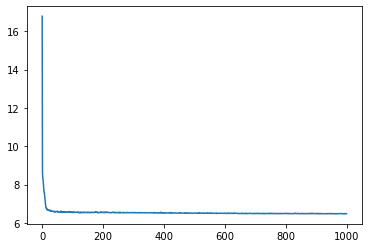

FOLD 2201
train [28.384607315063477, 6.547825813293457]
val [31.950138092041016, 6.765663146972656]
predict val...
predict test...
137.85382 254.03156
135.57434 254.03156 413.8828 1.0
FOLD 2202
train [29.246692657470703, 6.566744804382324]
val [29.220008850097656, 6.566047191619873]
predict val...
predict test...
121.70983 246.31158
154.3429 246.31158 399.06104 1.0
FOLD 2203
train [27.40013885498047, 6.477783203125]
val [37.08058547973633, 6.670680046081543]
predict val...
predict test...
161.14638 220.79562
111.05444 220.79562 463.45508 1.0
FOLD 2204
train [29.945388793945312, 6.61367130279541]
val [27.955734252929688, 6.505993843078613]
predict val...
predict test...
122.40009 241.80222
96.021545 241.80222 404.67676 1.0
FOLD 2205
train [28.8104190826416, 6.556158542633057]
val [32.76901626586914, 6.678378582000732]
predict val...
predict test...
143.1771 239.90582
139.76648 239.90582 361.12158 1.0
FOLD 2206
train [28.871999740600586, 6.5687689781188965]
val [32.292747497558594, 6.809

train [27.5526065826416, 6.483027458190918]
val [32.41807556152344, 6.834442138671875]
predict val...
predict test...
139.73518 221.97859
25.785156 221.97859 449.81152 1.0
FOLD 2247
train [27.037261962890625, 6.489067077636719]
val [31.372270584106445, 6.698430061340332]
predict val...
predict test...
133.69252 237.45683
124.59949 237.45683 368.4253 1.0
FOLD 2248
train [24.527984619140625, 6.358126163482666]
val [39.599578857421875, 6.727376937866211]
predict val...
predict test...
170.48128 211.76108
80.876465 211.76108 454.73413 1.0
FOLD 2249
train [27.41539192199707, 6.498291969299316]
val [28.627378463745117, 6.479287624359131]
predict val...
predict test...
124.577385 229.52286
71.174805 229.52286 299.09546 1.0
FOLD 2250
train [26.833118438720703, 6.458611965179443]
val [32.55634689331055, 6.745884418487549]
predict val...
predict test...
141.13795 224.32515
-10.591553 224.32515 379.2439 0.9869706840390879
FOLD 2251
train [33.38713455200195, 6.5568742752075195]
val [37.22194671630

train [31.20587730407715, 6.476171970367432]
val [35.14789962768555, 6.5631937980651855]
predict val...
predict test...
131.5529 228.35175
37.76709 228.35175 405.75488 1.0
FOLD 2292
train [30.505788803100586, 6.45989990234375]
val [37.95254135131836, 6.739832878112793]
predict val...
predict test...
141.49725 247.70256
118.28955 247.70256 424.4214 1.0
FOLD 2293
train [30.483251571655273, 6.440939903259277]
val [42.469688415527344, 6.67317008972168]
predict val...
predict test...
157.68776 222.6245
109.29126 222.6245 340.62207 1.0
FOLD 2294
train [31.99795150756836, 6.499951362609863]
val [34.594970703125, 6.618376731872559]
predict val...
predict test...
131.0921 235.21152
30.3833 235.21152 336.5935 1.0
FOLD 2295
train [30.27328109741211, 6.440810203552246]
val [38.05918502807617, 6.750887870788574]
predict val...
predict test...
142.85997 227.14912
-62.63623 227.14912 401.9724 0.9674267100977199
FOLD 2296
train [30.768598556518555, 6.46892786026001]
val [38.79119873046875, 6.856510639

train [34.40712356567383, 6.477810859680176]
val [41.58223342895508, 6.645864963531494]
predict val...
predict test...
135.53198 239.60535
96.069336 239.60535 347.7561 1.0
FOLD 2337
train [35.3498649597168, 6.4898786544799805]
val [41.49068832397461, 6.7045793533325195]
predict val...
predict test...
134.57973 234.6205
131.55835 234.6205 293.5017 1.0
FOLD 2338
train [32.74070358276367, 6.410401821136475]
val [50.57465362548828, 6.700281143188477]
predict val...
predict test...
164.73863 224.40614
111.50452 224.40614 386.39722 1.0
FOLD 2339
train [38.186092376708984, 6.5599188804626465]
val [35.885047912597656, 6.482741355895996]
predict val...
predict test...
120.319115 235.8124
147.70032 235.8124 311.01343 1.0
FOLD 2340
train [35.899986267089844, 6.485189914703369]
val [42.93570327758789, 6.731553077697754]
predict val...
predict test...
141.89642 226.85474
43.760254 226.85474 374.13525 1.0
FOLD 2341
train [34.855377197265625, 6.46826171875]
val [41.12548828125, 6.598447799682617]
pre

train [40.03009033203125, 6.499777793884277]
val [46.94694137573242, 6.7471184730529785]
predict val...
predict test...
136.92348 232.06291
105.03589 232.06291 345.86304 1.0
FOLD 2382
train [40.98583984375, 6.5319414138793945]
val [44.689727783203125, 6.567007064819336]
predict val...
predict test...
127.867516 242.81125
164.62671 242.81125 346.09668 1.0
FOLD 2383
train [37.901981353759766, 6.429683685302734]
val [55.33659362792969, 6.720756530761719]
predict val...
predict test...
160.14479 220.67816
87.447266 220.67816 330.22705 1.0
FOLD 2384
train [41.85638427734375, 6.552267551422119]
val [41.481048583984375, 6.509919166564941]
predict val...
predict test...
125.88186 243.99614
152.04187 243.99614 331.48047 1.0
FOLD 2385
train [39.3964729309082, 6.498038291931152]
val [48.130191802978516, 6.706769943237305]
predict val...
predict test...
141.37009 234.59749
130.76172 234.59749 318.47876 1.0
FOLD 2386
train [40.77381134033203, 6.51583194732666]
val [47.23270034790039, 6.846313476562

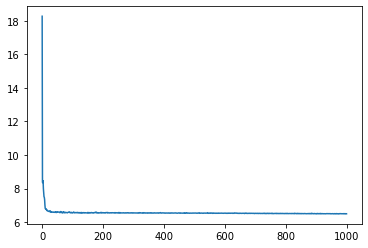

FOLD 2401
train [28.65472984313965, 6.534079551696777]
val [31.914949417114258, 6.771212577819824]
predict val...
predict test...
138.37335 237.24162
139.68347 237.24162 351.5376 1.0
FOLD 2402
train [28.855173110961914, 6.554037570953369]
val [30.146732330322266, 6.589653015136719]
predict val...
predict test...
125.03752 248.81693
144.17285 248.81693 417.6294 1.0
FOLD 2403
train [27.052059173583984, 6.472533226013184]
val [36.97590637207031, 6.6779069900512695]
predict val...
predict test...
160.86917 221.85551
117.09619 221.85551 442.64502 1.0
FOLD 2404
train [29.77627182006836, 6.61093807220459]
val [28.132530212402344, 6.495607376098633]
predict val...
predict test...
121.562805 244.80028
102.76007 244.80028 397.2251 1.0
FOLD 2405
train [28.966920852661133, 6.557763576507568]
val [32.21660614013672, 6.658719539642334]
predict val...
predict test...
140.40315 238.51349
116.25525 238.51349 390.1006 1.0
FOLD 2406
train [28.6422061920166, 6.554169654846191]
val [32.27312469482422, 6.78

train [27.941139221191406, 6.490649223327637]
val [31.975685119628906, 6.8275065422058105]
predict val...
predict test...
137.84259 225.6417
66.9646 225.6417 425.41943 1.0
FOLD 2447
train [27.492502212524414, 6.483192443847656]
val [30.0341854095459, 6.611316680908203]
predict val...
predict test...
129.51091 235.6864
100.34509 235.6864 403.29346 1.0
FOLD 2448
train [26.174190521240234, 6.427937984466553]
val [38.24925231933594, 6.689903736114502]
predict val...
predict test...
166.00804 221.14648
106.63818 221.14648 355.14038 1.0
FOLD 2449
train [27.362951278686523, 6.501777648925781]
val [27.77400016784668, 6.526979923248291]
predict val...
predict test...
119.60426 230.068
64.261475 230.068 376.68848 1.0
FOLD 2450
train [27.149141311645508, 6.466272830963135]
val [33.271690368652344, 6.75289249420166]
predict val...
predict test...
143.44908 218.04631
-49.725098 218.04631 392.57007 0.9804560260586319
FOLD 2451
train [33.225364685058594, 6.551611423492432]
val [37.5543327331543, 6.78

train [32.258182525634766, 6.5127692222595215]
val [36.5416145324707, 6.794940948486328]
predict val...
predict test...
134.57181 232.33551
82.72583 232.33551 345.09216 1.0
FOLD 2492
train [31.451114654541016, 6.503640651702881]
val [35.703582763671875, 6.618740081787109]
predict val...
predict test...
132.19081 239.4604
128.23828 239.4604 335.0747 1.0
FOLD 2493
train [29.32106590270996, 6.395016670227051]
val [40.77665328979492, 6.641852378845215]
predict val...
predict test...
150.38422 216.80511
74.007324 216.80511 332.9165 1.0
FOLD 2494
train [31.321565628051758, 6.479305267333984]
val [31.62943458557129, 6.415281295776367]
predict val...
predict test...
118.22241 224.41425
35.36548 224.41425 337.72632 1.0
FOLD 2495
train [31.442005157470703, 6.489412784576416]
val [38.44160461425781, 6.77164363861084]
predict val...
predict test...
143.45924 230.78995
-1.1743164 230.78995 410.34497 0.996742671009772
FOLD 2496
train [29.436796188354492, 6.396939277648926]
val [35.6660270690918, 6.6

train [36.236473083496094, 6.507533073425293]
val [43.17403793334961, 6.928705215454102]
predict val...
predict test...
141.92105 241.06406
55.714355 241.06406 489.48584 1.0
FOLD 2537
train [36.43009948730469, 6.510453701019287]
val [38.03525161743164, 6.542791366577148]
predict val...
predict test...
124.88908 249.71727
118.71936 249.71727 453.52393 1.0
FOLD 2538
train [33.55706787109375, 6.414671421051025]
val [49.85099411010742, 6.713030815124512]
predict val...
predict test...
163.22737 220.8242
77.66968 220.8242 337.92017 1.0
FOLD 2539
train [35.30937957763672, 6.475264072418213]
val [36.75348663330078, 6.458307266235352]
predict val...
predict test...
122.270386 230.56456
27.858887 230.56456 319.7744 1.0
FOLD 2540
train [36.85860061645508, 6.532339572906494]
val [44.51825714111328, 6.6924614906311035]
predict val...
predict test...
147.54936 234.33484
174.00708 234.33484 319.18213 1.0
FOLD 2541
train [34.015594482421875, 6.438181400299072]
val [43.5241813659668, 6.90929651260376]

train [39.999168395996094, 6.498484134674072]
val [53.41801452636719, 7.751524448394775]
predict val...
predict test...
152.49443 237.5607
-75.67456 237.5607 386.36475 0.9739413680781759
FOLD 2582
train [41.41556930541992, 6.545237064361572]
val [45.19972229003906, 6.601789474487305]
predict val...
predict test...
129.93427 247.34222
161.29431 247.34222 384.53223 1.0
FOLD 2583
train [38.075443267822266, 6.429600715637207]
val [55.121158599853516, 6.674887657165527]
predict val...
predict test...
160.09703 225.99162
93.41406 225.99162 355.85474 1.0
FOLD 2584
train [41.53175735473633, 6.540380001068115]
val [41.711708068847656, 6.50046968460083]
predict val...
predict test...
126.55031 240.03426
35.367676 240.03426 338.03125 1.0
FOLD 2585
train [40.57893753051758, 6.500269889831543]
val [49.448246002197266, 6.780055999755859]
predict val...
predict test...
144.6874 235.09065
21.338867 235.09065 426.57178 1.0
FOLD 2586
train [40.03166198730469, 6.495597839355469]
val [47.38450622558594, 6

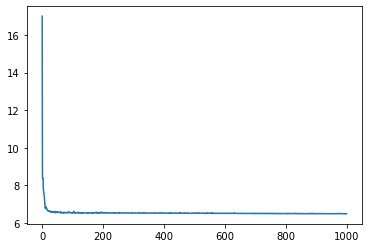

FOLD 2601
train [28.79023551940918, 6.55869197845459]
val [32.051876068115234, 6.763440132141113]
predict val...
predict test...
139.52771 255.09831
139.71191 255.09831 416.4922 1.0
FOLD 2602
train [29.210962295532227, 6.566061973571777]
val [29.53026008605957, 6.598511695861816]
predict val...
predict test...
122.62566 251.57217
139.83594 251.57217 428.1621 1.0
FOLD 2603
train [27.001771926879883, 6.470405578613281]
val [37.40245056152344, 6.7353997230529785]
predict val...
predict test...
161.33041 223.2983
105.80835 223.2983 407.7417 1.0
FOLD 2604
train [29.965900421142578, 6.617769718170166]
val [27.90172576904297, 6.510166645050049]
predict val...
predict test...
121.9392 245.09486
105.21307 245.09486 397.67676 1.0
FOLD 2605
train [28.774213790893555, 6.546341896057129]
val [32.545440673828125, 6.656665325164795]
predict val...
predict test...
142.78049 234.11125
107.996765 234.11125 395.48438 1.0
FOLD 2606
train [28.305660247802734, 6.544921875]
val [31.38532829284668, 6.73983049

train [26.531494140625, 6.44785213470459]
val [31.409290313720703, 6.709972381591797]
predict val...
predict test...
132.97783 213.72923
44.279297 213.72923 349.40723 1.0
FOLD 2647
train [27.42707633972168, 6.498363494873047]
val [32.14415740966797, 6.695441246032715]
predict val...
predict test...
138.3247 239.6545
111.08362 239.6545 334.11133 1.0
FOLD 2648
train [25.749807357788086, 6.390530109405518]
val [35.92491149902344, 6.647496223449707]
predict val...
predict test...
154.52318 208.28761
70.791504 208.28761 342.74048 1.0
FOLD 2649
train [27.218725204467773, 6.477681636810303]
val [27.919479370117188, 6.472171306610107]
predict val...
predict test...
123.610306 232.46796
38.059814 232.46796 404.8789 1.0
FOLD 2650
train [25.929567337036133, 6.433154106140137]
val [34.751686096191406, 6.859968185424805]
predict val...
predict test...
146.8142 225.33122
-221.51953 225.33122 434.1626 0.9641693811074918
FOLD 2651
train [33.34911346435547, 6.5679216384887695]
val [36.822025299072266, 

train [29.1010799407959, 6.397587776184082]
val [34.62441635131836, 6.6341471672058105]
predict val...
predict test...
129.07617 214.2526
19.970703 214.2526 415.7212 1.0
FOLD 2692
train [29.987628936767578, 6.421269416809082]
val [35.33584213256836, 6.643789291381836]
predict val...
predict test...
132.08438 229.50102
76.03638 229.50102 322.1665 1.0
FOLD 2693
train [29.732908248901367, 6.414823055267334]
val [44.21738052368164, 6.72799015045166]
predict val...
predict test...
164.46393 227.4543
74.910645 227.4543 438.80298 1.0
FOLD 2694
train [31.552366256713867, 6.484236717224121]
val [32.334739685058594, 6.465845108032227]
predict val...
predict test...
121.32186 235.28087
14.944824 235.28087 376.16943 1.0
FOLD 2695
train [30.21602439880371, 6.455292701721191]
val [36.84951400756836, 6.684595108032227]
predict val...
predict test...
137.42844 226.91449
-84.595215 226.91449 368.3286 0.9674267100977199
FOLD 2696
train [32.05356979370117, 6.499230861663818]
val [37.92335891723633, 6.981

train [35.261329650878906, 6.481501579284668]
val [40.321285247802734, 6.514071464538574]
predict val...
predict test...
132.50824 234.11708
-3.6625977 234.11708 487.36914 0.996742671009772
FOLD 2737
train [36.23959732055664, 6.512594699859619]
val [43.30131530761719, 6.718597412109375]
predict val...
predict test...
140.59256 244.9426
129.56494 244.9426 350.84766 1.0
FOLD 2738
train [34.49280548095703, 6.433831691741943]
val [49.61153030395508, 6.69619083404541]
predict val...
predict test...
162.45222 226.4728
81.282715 226.4728 395.9309 1.0
FOLD 2739
train [36.73527526855469, 6.5260009765625]
val [37.216094970703125, 6.494070053100586]
predict val...
predict test...
124.95188 239.86151
30.22705 239.86151 361.66748 1.0
FOLD 2740
train [34.66998291015625, 6.464182376861572]
val [45.59941482543945, 6.752883434295654]
predict val...
predict test...
150.59448 230.55843
82.27881 230.55843 354.5039 1.0
FOLD 2741
train [35.99394226074219, 6.489270210266113]
val [43.40006637573242, 6.9342055

train [40.4967041015625, 6.508606910705566]
val [47.45072937011719, 6.907375335693359]
predict val...
predict test...
136.99387 238.55382
23.470703 238.55382 449.69873 1.0
FOLD 2782
train [38.94483184814453, 6.474557399749756]
val [55.25033187866211, 7.593179702758789]
predict val...
predict test...
156.45819 237.23758
103.97412 237.23758 352.53857 1.0
FOLD 2783
train [34.74364471435547, 6.337918758392334]
val [55.67123794555664, 6.683741569519043]
predict val...
predict test...
159.03397 198.4596
51.16211 198.4596 302.6936 1.0
FOLD 2784
train [40.71084976196289, 6.5201520919799805]
val [41.24143981933594, 6.47824239730835]
predict val...
predict test...
122.51153 235.68195
74.91162 235.68195 320.96704 1.0
FOLD 2785
train [38.527809143066406, 6.470895290374756]
val [47.66590881347656, 6.716320037841797]
predict val...
predict test...
141.75378 234.3038
42.531982 234.3038 363.95728 1.0
FOLD 2786
train [36.722808837890625, 6.405248165130615]
val [45.74485778808594, 6.9628095626831055]
pr

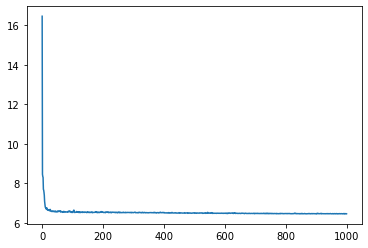

CPU times: user 20h 27min 26s, sys: 2h 3min 47s, total: 22h 31min 14s
Wall time: 15h 55min 50s


In [150]:
%%time
cnt = 0
resultsigma_opt = []
resultsigma_mean = []
resultmin = []
resultmean = []
resultmax = []

Qa=[]
MLa=[]
Da=[]
EPOCHSa=[]
Fold = []
Scorea = []

#EPOCHS=800
for D in np.arange(10,150,10):
    for ML in np.arange(.5,.9,0.1):
        for EPOCHS in range(100,1100,100):
            for tr_idx, val_idx in kf.split(z):
                pred = np.zeros((z.shape[0], 3))
                nh = z.shape[1]
                pe = np.zeros((ze.shape[0], 3))

                cnt += 1
                print(f"FOLD {cnt}")
                net = make_model(nh,D,ML)
                History = net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(z[val_idx], y[val_idx]), verbose=0) #
                print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
                print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
                print("predict val...")
                pred = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
                print("predict test...")
                pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
                #Scores = score_fold(y_true = y, y_pred = pred)

                sigma_opt = mean_absolute_error(y[val_idx], pred[:, 1])
                unc = pred[:, 2] - pred[:, 0]
                sigma_mean = np.mean(unc)
                print(sigma_opt, sigma_mean)
                print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
                um=unc.min().astype(np.float32)
                umn=unc.mean().astype(np.float32)
                umx=unc.max().astype(np.float32)

                resultsigma_opt.append(sigma_opt)
                resultsigma_mean.append(sigma_mean)
                resultmin.append(um) 
                resultmean.append(umn) 
                resultmax.append(umx) 
                #Scorea.append(Scores)

                Qa.append(BATCH_SIZE) 
                Da.append(D) 
                MLa.append(ML)
                EPOCHSa.append(EPOCHS)
                Fold.append({cnt})

                del(net,um,umn,umx,sigma_mean,unc, sigma_opt, pe,pred)

    pyplot.plot(History.history['score'])
    pyplot.show()              
#==============

array([2315., 2214., 2061., ..., 2908., 2975., 2774.], dtype=float32)

In [151]:
conf_list = [resultsigma_opt,resultsigma_mean,resultmin,resultmean,resultmax,Da,MLa,EPOCHSa,Qa,Fold]

Confidence = pd.DataFrame(conf_list).transpose()
Confidence.columns = [['resultsigma_opt','resultsigma_mean','resultmin','resultmean','resultmax','Da','MLa','EPOCHSa','Qa','Fold']]

#confidenceMin = Confidence.sort_values('resultsigma_opt').iloc[[0]]
Confidence
Confidence.to_csv("Confidence.csv", index=False)

In [152]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:, 2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
um=unc.min() .astype(np.float32)
umn=unc.mean().astype(np.float32)
umx=unc.max().astype(np.float32)

um


NameError: name 'pred' is not defined

In [ ]:
idxs = np.random.randint(0, y.shape[0], 10)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [ ]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

In [ ]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

### PREDICTION

In [ ]:
sub.head()

In [ ]:
sub['FVC1'] = pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].head(10)

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.head()

In [ ]:
subm.describe().T

In [ ]:
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
sub80 = pd.read_csv("../input/sub800/submission.csv")
#df1=pd.concat([sub80, subm.loc], axis=1, ignore_index=True)
plt.plot(sub80.FVC, subm.FVC, label="ground truth")
sub80 = pd.DataFrame(sub80)
#subm = pd.DataFrame(subm)
#sub80["FVCdif"] = sub80["FVC"] - subm["FVC"]

plt.show()
print(sub80)